In [74]:
using Agents
using Graphs
using DynamicalSystems
using InteractiveDynamics
using GLMakie
using CairoMakie
using GraphMakie
using Karnak, Luxor, Colors
using NetworkLayout
using Plots
using StatsPlots

using Random
using Measures
using Compose, Cairo, Fontconfig
using LaTeXStrings
using StatsBase

using LinearAlgebra
using DataFrames

### Create Graph Space

In [75]:
SEED = 123

123

In [76]:
# set up the dims of grid
const NN = 13
const GRID_DIM = (NN,NN)

# agent num = 75% of the node
TOTAL_AGENTS = round( Int, 0.75*prod(GRID_DIM) );

# make a lattice grid graph space
# residential_graph = Graphs.grid( GRID_DIM, periodic=false )

In [77]:
# Randomly deciding whether to add or remove edges to simulates the dynamic alteration of edges in the graph

function AdjustGraph(graph, THRESHOLD_RAND_EDGE_ADD, THRESHOLD_RAND_EDGE_RM)

    for source_node in vertices(graph)

        # add edge
        if( rand() < THRESHOLD_RAND_EDGE_ADD )
            destination_node = rand( 1:nv(graph), 1)[1]

            if( destination_node != source_node )
                add_edge!(graph, source_node, destination_node)
            end
        end

        # remove edge
        if( rand() < THRESHOLD_RAND_EDGE_RM )
            neighbors = all_neighbors(graph, source_node)

            if( length(neighbors) > 0 )
                neighbor = rand( neighbors, 1)[1]
                rem_edge!(graph, source_node, neighbor)
            end
        end
    end
    return graph
end

AdjustGraph (generic function with 1 method)

In [78]:
# Function to generate different num of edges of graphs

function DiffEdgesGraphs(num_graphs, NN, THRESHOLD_RAND_EDGE_ADD, THRESHOLD_RAND_EDGE_RM)
    graphs = []
    GRID_DIM = (NN,NN)
    for i in 1:num_graphs
        residential_graph = Graphs.grid(GRID_DIM, periodic=false)
        
        adjusted_graph = AdjustGraph(residential_graph, THRESHOLD_RAND_EDGE_ADD, THRESHOLD_RAND_EDGE_RM)
        
        push!(graphs, adjusted_graph)
    end
    
    return graphs
end

DiffEdgesGraphs (generic function with 1 method)

### Model initial function

In [79]:
# Define Agent
@agent GraphSchellingAgent GraphAgent begin
    remain::Union{Number ,Bool}
    group::Int
end

In [80]:
# for modelstep!
model_iteration = 0;

In [81]:
rng1 = Random.Xoshiro(SEED)

Xoshiro(0xfefa8d41b8f5dca5, 0xf80cc98e147960c1, 0x20e2ccc17662fc1d, 0xea7a7dcb2e787c01)

In [82]:
function initialize(graph)
    global model_iteration = 0
    
    space = GraphSpace(graph)
    
    # The properties in model will now hold the min remain percentage = 0.5
    properties = Dict( :min_remain_percentage => 0.5 )
    
    # Set model as unremovable agent based model
    model = UnremovableABM(GraphSchellingAgent, space; properties, 
                            rng=rng1, scheduler=Schedulers.Randomly() )
    
    # populate the model with agents, adding equal amount of the two types of agents at random positions in the model
    for agent_ind in 1:TOTAL_AGENTS
        remain_temp = false
        group_temp = agent_ind < TOTAL_AGENTS/2 ? 1 : 2
        new_position = random_empty(model)
        
        agent_temp = GraphSchellingAgent(agent_ind, new_position, remain_temp, group_temp)
        add_agent!(agent_temp, model)
    end
    return model
end

initialize (generic function with 1 method)

### Agent step & model step

This part is to define how we decide if the agent is going to move to next positoin based on the homogeneity and if they will be satisfy

In [83]:
# Get the position's nearby info include num of nearby position and homogeneity. 
# Can be use to get current agent & next positoin's nearby info

function PositionStatus(group, position, model)
    count_near = 0
    for pos in nearby_positions(position, model,1)
        count_near += 1
    end
    
    count_neighbors_same_group = 0    
    for id in nearby_ids( position, model , 1)
        agent = model[id]
        if agent.group == group
            count_neighbors_same_group += 1
        end
    end
    
    return [count_near, count_neighbors_same_group]
    
end

PositionStatus (generic function with 1 method)

In [84]:
# Caculate the urban level
# Reason: to prevent agent get into bad cycle because they move to a less connect hub(position that have less edges)

function NeighborhoodProb(pos_new, model)
    neighbor_num_vec = []
    
    for agent_tmp in allagents(model)
        nearby_num = length(collect(nearby_positions(agent_tmp.pos, model)))
        push!(neighbor_num_vec, nearby_num)
    end
    
    nearby_num = length(collect(nearby_positions(pos_new, model)))
    push!(neighbor_num_vec, nearby_num)
    
    unique_neighbor_num = unique(neighbor_num_vec)
    prob_remain = Dict()
    
    for k in unique_neighbor_num
        prob_remain[k] = 1 - (length(findall(k .< neighbor_num_vec))/length(neighbor_num_vec))
    end
         
    return prob_remain[length(collect(nearby_positions(pos_new, model)))]
end

NeighborhoodProb (generic function with 1 method)

In [85]:
# Decide if the next position would satisfy the agent
function NextPosition(agent, model)
    
    rand_pos = random_empty(model)
    count_near, count_neighbors_same_group = PositionStatus(agent.group, rand_pos, model)
    identify_stat = (count_neighbors_same_group / count_near) >= model.min_remain_percentage 

    # if the homogeneity doesn't satisfy. Reject moving.
    if(identify_stat != true)
        return -1
    end

    neigbor_prob = NeighborhoodProb(rand_pos, model)

    if( Int(identify_stat) * neigbor_prob > rand() ) 
        return rand_pos
    else
        return -1

    end
end

NextPosition (generic function with 1 method)

In [86]:
function agent_step!(agent, model)

    # Get current agent's nearby info
    count_near, count_neighbors_same_group = PositionStatus(agent.group, agent.pos, model)
    
    remain_current = (count_neighbors_same_group / count_near) >= model.min_remain_percentage
    if remain_current == true
        agent.remain = 1
        return 
    end
       
    # Get next posible place's nearby info
    newPosition = NextPosition(agent, model)
    # if newPosition is not -1, means the next position is better than current.
    if newPosition == -1
        agent.remain = 0
        return
    else
        agent.remain = 1
        move_agent!(agent , newPosition, model)
    end

end

agent_step! (generic function with 1 method)

In [87]:
function model_step!(model)
     global model_iteration += 1 
end

model_step! (generic function with 1 method)

### Entropy Calculation Functions

H(x)=−p(x)ln(p(x))

https://chat.openai.com/share/2f8b5ccf-beee-4bbc-a036-61b9b58245e1

In [88]:
# Get the % of agent stay in their pos
function ModelRemainTrajectory(model)
    remain = 0
    for agent in allagents(model)
        remain += agent.remain 
    end
    return remain / nagents(model)
end

# Caculate graph entropy (Trace State) based on agent's group homogeneity
function GraphBaseEntropy(model)
    
    edge_total_num = 0
    agent_degree_distribution = Dict()
        
    for agent in allagents(model)
        edge_num = 0
        
        for near_agent in nearby_agents(agent,model, 1)
           if near_agent.group == agent.group
               edge_num += 1 
            end           
        end
        
        edge_total_num += edge_num
        
        if edge_num in keys(agent_degree_distribution)
            agent_degree_distribution[edge_num] += 1
        else
            agent_degree_distribution[edge_num] = 1
        end    
    end
    
    # Get agent_degree_distribution prob
    for k in keys(agent_degree_distribution)
        agent_degree_distribution[k] /= edge_total_num
    end
    
    #println(agent_degree_distribution)
    H = 0
    
     for k in keys(agent_degree_distribution)
        H += (-1) * agent_degree_distribution[k] * log(agent_degree_distribution[k])
        
    end
    
    return H
end

# Caculate graph entropy(Macro) based on node's connection
function GraphSpaceEntropy(model)
    G = model.space.graph

    node_total_num = nv(G)
    node_dregree_distrubution = Dict()
    
    for v in vertices(G)
        edge_num = length(collect(neighbors(G, v)))
        if edge_num in keys(node_dregree_distrubution)
            node_dregree_distrubution[edge_num] += 1
        else
            node_dregree_distrubution[edge_num] = 1
        end  
    end
    
    for k in keys(node_dregree_distrubution)
        node_dregree_distrubution[k] /= node_total_num
    end
    
    #println(node_dregree_distrubution)
    H = 0
    
    for k in keys(node_dregree_distrubution)
        H += (-1) * node_dregree_distrubution[k] * log(node_dregree_distrubution[k])       
    end

    return H

end


GraphSpaceEntropy (generic function with 1 method)

### Create different graph space

In [89]:
graphs = []
push!(graphs, DiffEdgesGraphs(1, 13, 0.0, 0.0))
push!(graphs, DiffEdgesGraphs(1, 13, 0.0, 0.40))
push!(graphs, DiffEdgesGraphs(1, 13, 0.0, 0.90))
push!(graphs, DiffEdgesGraphs(1, 13, 0.40, 0.0))
push!(graphs, DiffEdgesGraphs(1, 13, 0.90, 0.0))
push!(graphs, DiffEdgesGraphs(1, 13, 0.20, 0.20))
push!(graphs, DiffEdgesGraphs(1, 13, 0.70, 0.70)) 

7-element Vector{Any}:
 Any[SimpleGraph{Int64}(312, [[2, 14], [1, 3, 15], [2, 4, 16], [3, 5, 17], [4, 6, 18], [5, 7, 19], [6, 8, 20], [7, 9, 21], [8, 10, 22], [9, 11, 23]  …  [147, 159, 161], [148, 160, 162], [149, 161, 163], [150, 162, 164], [151, 163, 165], [152, 164, 166], [153, 165, 167], [154, 166, 168], [155, 167, 169], [156, 168]])]
 Any[SimpleGraph{Int64}(251, [[2, 14], [1, 3], [2, 16], [5, 17], [4, 6, 18], [5, 7, 19], [6, 8, 20], [7, 9], [8, 10, 22], [9, 11]  …  [147, 161], [148, 160], [149], Int64[], [151, 165], [152, 164], [153, 167], [166], [155], Int64[]])]
 Any[SimpleGraph{Int64}(158, [[14], [3], [2, 4], [3, 5], [4], [7, 19], [6], [9], [8], [11, 23]  …  [161], [148, 160], Int64[], [150, 164], [163], Int64[], [167], [166, 168], [167], [156]])]
 Any[SimpleGraph{Int64}(370, [[2, 14], [1, 3, 15, 52], [2, 4, 16, 24], [3, 5, 17], [4, 6, 18, 98], [5, 7, 19, 46, 130], [6, 8, 20], [7, 9, 21], [8, 10, 22], [9, 11, 23]  …  [147, 159, 161], [148, 160, 162], [108, 149, 161, 163], [120

### Create model on graph space and get model data

In [90]:
# initialize models on same graph
models = []
for graph in graphs
    model = initialize(graph[1])
    push!(models, model)

end

# Get the remain%, Entropy based on agent, and Entropy of the whole graph
mdata = [ModelRemainTrajectory, GraphBaseEntropy, GraphSpaceEntropy]
step_num = 100

df = []
remain = []
graph_base_H =[]
graph_space_H = []

for (index, model) in pairs(models)
    
    _, model_df = run!(model, agent_step!, step_num; mdata)
    
    push!(df, model_df)
    push!(remain, model_df[:,:ModelRemainTrajectory])
    push!(graph_base_H, model_df[:,:GraphBaseEntropy])
    push!(graph_space_H, model_df[:,:GraphSpaceEntropy])
end

LOOPS = 1:100

for i in LOOPS
    # initialize models on same graph
    models = Vector{Any}()
    for graph in graphs
        model = initialize(graph[1])
        push!(models, model)
        
    end

    for (index, model) in pairs(models)

        _, model_df = run!(model, agent_step!, step_num; mdata)
        graph_base_H[index] += model_df[:,:GraphBaseEntropy]
        remain[index] += model_df[:,:ModelRemainTrajectory]
    end
end

graph_base_H /= 1+length(LOOPS);
remain /= 1+length(LOOPS);


### Calculate the rho and visualize

In [91]:
HGs = [g[1] for g in graph_space_H]
HGs = [round(h; digits=3) for h in HGs]
HGstr = [L"H_g="*"$(h)" for h in HGs]
HGstr = permutedims(HGstr)


1×7 Matrix{String}:
 "\$H_g=\$0.678"  "\$H_g=\$1.25"  …  "\$H_g=\$1.282"  "\$H_g=\$1.677"

In [92]:
remain_ends = [remain[i][end] for i in 1:length(remain)]

s_score_remain = corspearman(HGs, remain_ends)
s_score_remain = round(s_score_remain; digits=3)

-0.408

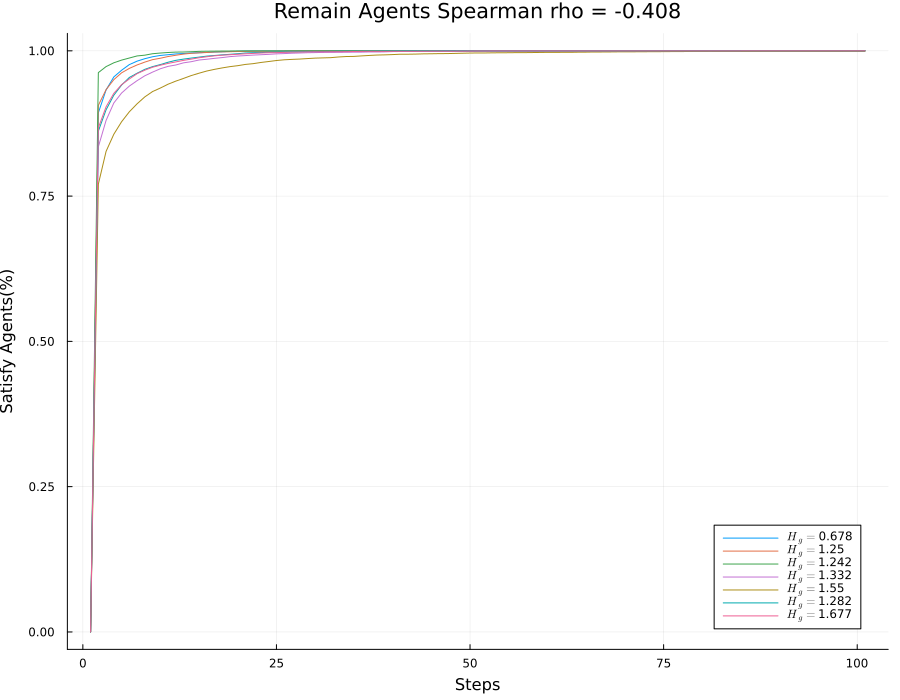

In [93]:
p1 = Plots.plot(remain, xlabel = "Steps",ylabel = "Satisfy Agents(%)",legend=true,labels = HGstr, title="Remain Agents Spearman rho = $(s_score_remain)", size=(900, 700))

In [94]:
# savefig(p1 , "./plots/RemainUrbanRank.pdf")

In [95]:
entropy_ends = [graph_base_H[i][end] for i in 1:length(graph_base_H)]
s_score_entropy = corspearman(HGs, entropy_ends)
s_score_entropy = round(s_score_entropy; digits=3)

-0.357

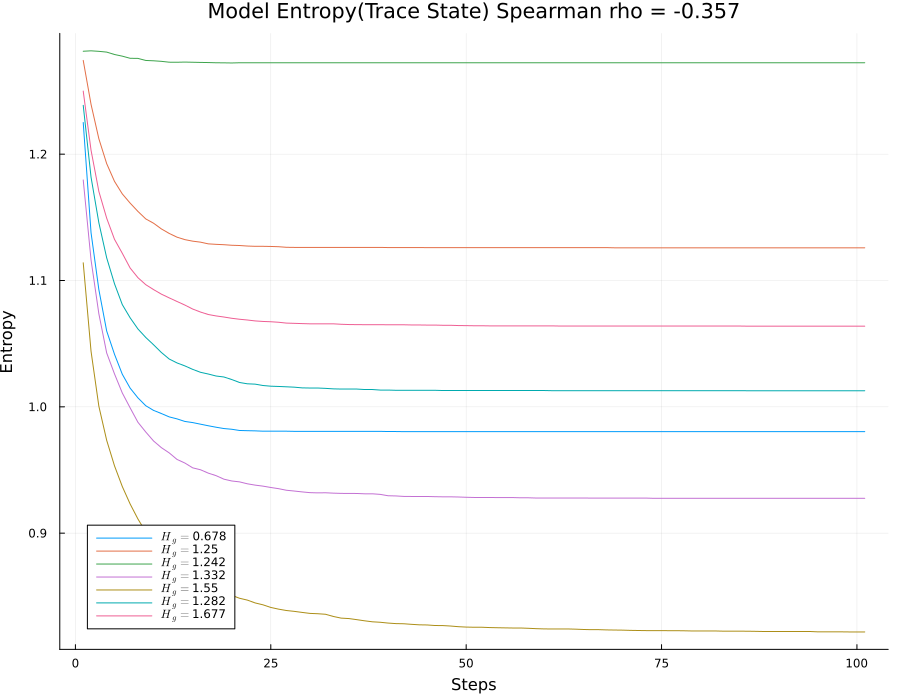

In [96]:
p2 = Plots.plot(graph_base_H, xlabel = "Steps",ylabel = "Entropy",legend=true, labels = HGstr,title="Model Entropy(Trace State) Spearman rho = $(s_score_entropy)", size=(900, 700))

In [97]:
# savefig(p2 , "./plots/EntropyUrbanRank.pdf")

### Different network types

Barabasi Albert
Scale Free
Random

In [98]:
num_nodes = prod(GRID_DIM)
num_edges = ne(graphs[1][1])
num_hub = 1
barabasi_albert_residential_graph_1 = Graphs.barabasi_albert(num_nodes, 5)
barabasi_albert_residential_graph_2 = Graphs.barabasi_albert(num_nodes, 3)

{169, 498} undirected simple Int64 graph

In [99]:
scale_free_residential_graph_1 = Graphs.static_scale_free(num_nodes,num_edges,2)
scale_free_residential_graph_2 = Graphs.static_scale_free(num_nodes,num_edges,3)

{169, 312} undirected simple Int64 graph

In [100]:
random_residential_graph = Graphs.random_regular_graph(num_nodes, 4)

{169, 338} undirected simple Int64 graph

In [101]:
newman_watts_strogatz_residential_graph = Graphs.newman_watts_strogatz(num_nodes, 4, 0.3)

{169, 446} undirected simple Int64 graph

In [102]:
diff_graphs = []

push!(diff_graphs, barabasi_albert_residential_graph_1)
push!(diff_graphs, barabasi_albert_residential_graph_2)
push!(diff_graphs, scale_free_residential_graph_1)
push!(diff_graphs, scale_free_residential_graph_2)
push!(diff_graphs, newman_watts_strogatz_residential_graph)
push!(diff_graphs, DiffEdgesGraphs(1, 13, 0.0, 0.0)[1])

6-element Vector{Any}:
 {169, 820} undirected simple Int64 graph
 {169, 498} undirected simple Int64 graph
 {169, 312} undirected simple Int64 graph
 {169, 312} undirected simple Int64 graph
 {169, 446} undirected simple Int64 graph
 {169, 312} undirected simple Int64 graph

In [103]:
diff_graph_models = []
for graph in diff_graphs
    model = initialize(graph)
    push!(diff_graph_models, model)

end

# Get the remain%, Entropy based on agent, and Entropy of the whole graph
mdata = [ModelRemainTrajectory, GraphBaseEntropy, GraphSpaceEntropy]
step_num = 100

remain = []
graph_base_H =[]
graph_space_H = []

for (index, model) in pairs(diff_graph_models)
    
    _, model_df = run!(model, agent_step!, step_num; mdata)
    
    push!(df, model_df)
    push!(remain, model_df[:,:ModelRemainTrajectory])
    push!(graph_base_H, model_df[:,:GraphBaseEntropy])
    push!(graph_space_H, model_df[:,:GraphSpaceEntropy])
end

LOOPS = 1:100

for i in LOOPS
    # initialize models on same graph
    models =[]
    for graph in diff_graphs
        model = initialize(graph)
        push!(models, model)
        
    end

    for (index, model) in pairs(models)

        _, model_df = run!(model, agent_step!, step_num; mdata)
        graph_base_H[index] += model_df[:,:GraphBaseEntropy]
        remain[index] += model_df[:,:ModelRemainTrajectory]
    end
end

graph_base_H /= 1+length(LOOPS);
remain /= 1+length(LOOPS);

In [104]:
HGs = [g[1] for g in graph_space_H]
HGs = [round(h; digits=3) for h in HGs]
#HGstr = [L"H_g="*"$(h)" for h in HGs]
HGstr = [L"H_{BA1}="*"$(HGs[1])", L"H_{BA2}="*"$(HGs[2])",L"H_{SF1}="*"$(HGs[3])", L"H_{SF2}="*"$(HGs[4])",L"H_{NWS}="*"$(HGs[5])", L"H_{Grid}="*"$(HGs[6])"]

HGstr = permutedims(HGstr)

1×6 Matrix{String}:
 "\$H_{BA1}=\$2.394"  "\$H_{BA2}=\$2.013"  …  "\$H_{Grid}=\$0.678"

In [105]:
remain_ends = [remain[i][end] for i in 1:length(remain)]

s_score_remain = corspearman(HGs, remain_ends)
s_score_remain = round(s_score_remain; digits=3)

-0.899

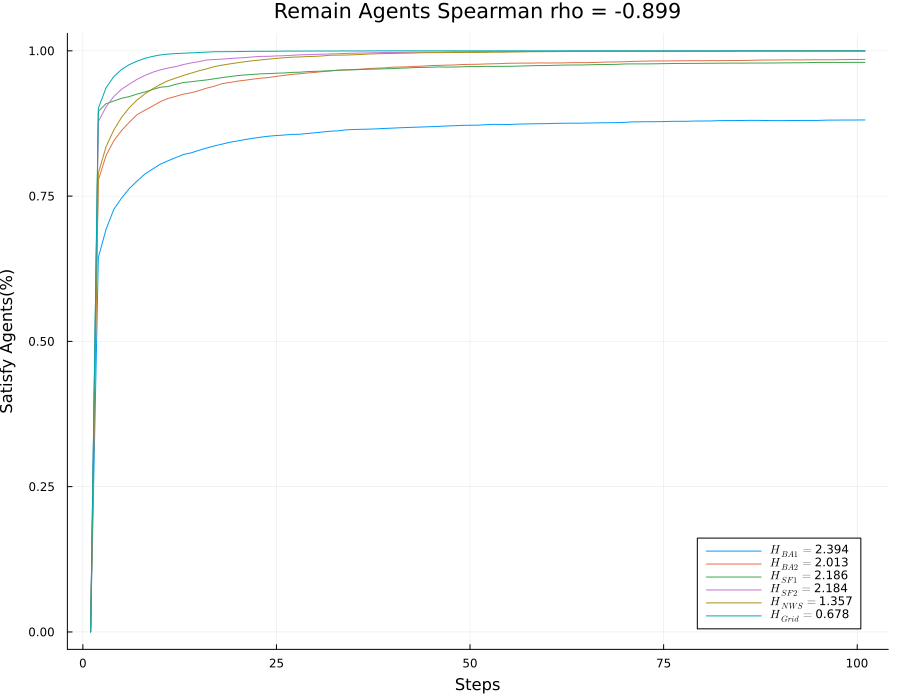

In [106]:
p3 = Plots.plot(remain, xlabel = "Steps",ylabel = "Satisfy Agents(%)",legend=true,labels = HGstr, title="Remain Agents Spearman rho = $(s_score_remain)", size=(900, 700))

In [107]:
# savefig(p3 , "./plots/RemainUrbanRank_Diff_network.pdf")

In [108]:
entropy_ends = [graph_base_H[i][end] for i in 1:length(graph_base_H)]
s_score_entropy = corspearman(HGs, entropy_ends)
s_score_entropy = round(s_score_entropy; digits=3)

-0.029

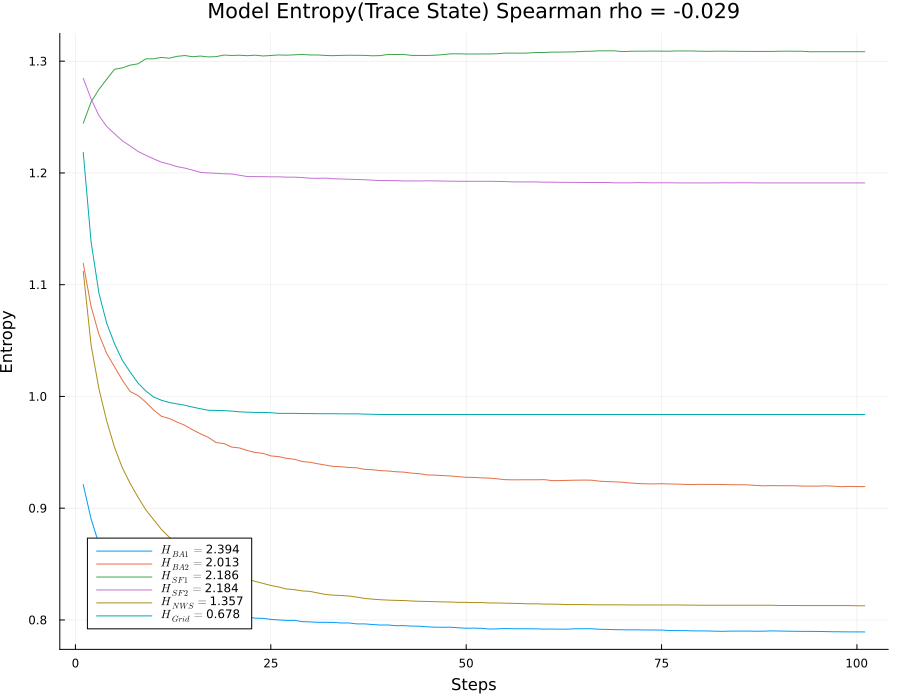

In [109]:
p4 = Plots.plot(graph_base_H, xlabel = "Steps",ylabel = "Entropy",legend=true, labels = HGstr,title="Model Entropy(Trace State) Spearman rho = $(s_score_entropy)", size=(900, 700))

In [110]:
# savefig(p4 , "./plots/EntropyUrbanRank_Diff_network.pdf")

### Color node based on group

In [111]:
function VertexFillColors(graph, model)    
    vertex_colors = [ RGB(0, 0, 0) for i in 1:nv(graph) ]
    
    for agent in model.agents
        
        if( agent.group == 1 )
            vertex_colors[ agent.pos ] = RGB(1, 0.65, 0)
        else 
            vertex_colors[ agent.pos ] = RGB(0, 0, 1)
        end        
    end
    
    return vertex_colors
end

VertexFillColors (generic function with 1 method)

In [112]:
# Shape: Square means satisfy, circle means not

function VertexShape(graph, model)    
    vertex_shape = [:circle for i in 1:nv(graph)]
    
    for agent in model.agents
        
        if( agent.remain==true)
            vertex_shape[ agent.pos ] = :square
        else 
            vertex_shape[ agent.pos ] = :circle
        end        
    end
    
    return vertex_shape
end

VertexShape (generic function with 1 method)

### Visualize Graph after Steps

In [113]:
values_to_select = [0, 5, 10, 15, 20, 25, 30]
selected_rows = filter(row -> row.step in values_to_select, df[1])

,step,ModelRemainTrajectory,GraphBaseEntropy,GraphSpaceEntropy
,Int64,Float64,Float64,Float64
1,0,0.0,1.28332,0.678182
2,5,0.976378,1.0681,0.678182
3,10,1.0,1.01761,0.678182
4,15,1.0,1.01761,0.678182
5,20,1.0,1.01761,0.678182
6,25,1.0,1.01761,0.678182
7,30,1.0,1.01761,0.678182


In [114]:
fulfillStep = []

# Iterate over each DataFrame
for data in df
    # Find the index where "ModelRemainTrajectory" first reaches 1.0
    idx = findfirst(isequal(1.0), data.ModelRemainTrajectory)
    
    if idx !== nothing
        # If 1.0 is found in "ModelRemainTrajectory," get the corresponding "step" value
        push!(fulfillStep, data.step[idx])
    else
        # If 1.0 is not found, push a placeholder value (e.g., NaN)
        push!(fulfillStep, NaN)
    end
end


println(fulfillStep)

Any[9, 9, 13, 18, 98, 25, 39, NaN, NaN, NaN, 68, 28, 5]


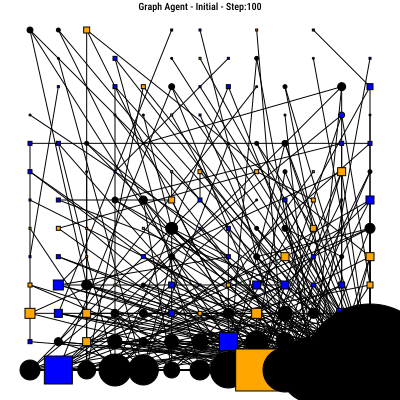

In [115]:
models = []
for graph in diff_graphs
    model = initialize(graph)
    push!(models, model)

end

graph = diff_graphs[3]
step_num = 100
step!(models[3], agent_step!, step_num)
pic = @drawsvg begin
    background("white")
    drawgraph(graph, 
        layout=squaregrid,
        vertexshapes = VertexShape(graph, models[3]),
        vertexshapesizes = [Graphs.outdegree(graph, v) for v in Graphs.vertices(graph)],
        vertexfillcolors = VertexFillColors(graph, models[3]) )
    Karnak.text( "Graph Agent - Initial - Step:100", boxtopcenter() + (0, 10), halign=:center)
end 400 400


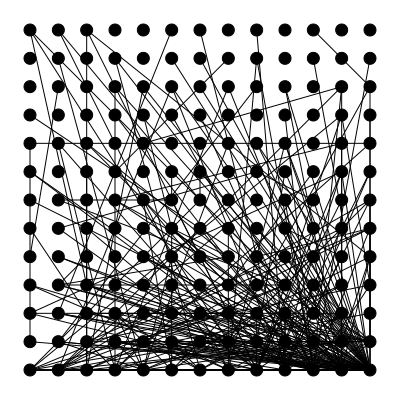

In [116]:
@drawsvg begin
    background("white")
    drawgraph(diff_graphs[3], 
         layout=squaregrid)
end 400 400

### Reforge Open Street Map Graph

In [117]:
map_path = OSM.test_map()

"/home/resort/.julia/artifacts/d76ce2a1e7d9391f335065cbab546eb7d8f89a97/osm_map_gottingen.json"

In [118]:
map_space=  OpenStreetMapSpace(map_path)

[ Info: Created OSMGraph object with kwargs: `network_type=drive`, `weight_type=distance`, `graph_type=static`, `precompute_dijkstra_states=false`, `largest_connected_component=true`


OpenStreetMapSpace with 598 ways and 2177 nodes

In [119]:
typeof(map_space.map.graph)

StaticGraphs.StaticDiGraph{Int32, Int32}

https://github.com/JuliaGraphs/StaticGraphs.jlMemory-efficient, performant graph structures optimized for large networks. Uses Graphs.

Note: adding/removing edges and vertices is not supported with this graph type.

Also the originl graph is not easy to use, so i just re-forge it into a SimpleGraph.

In [120]:
# Get all the node info in map (id, lat,lng)
nodes_pos = []

for k in keys(map_space.map.nodes)
    new_node = [string(map_space.map.nodes[k].id), map_space.map.nodes[k].location.lat, map_space.map.nodes[k].location.lon]

    push!(nodes_pos, new_node)
end

In [121]:
# get edge information
# create dataframe to create matrix alike things to create graph
edges = collect(keys(map_space.map.edge_to_way))
all_node_ids = Set(Iterators.flatten(edges))

nodes = collect(all_node_ids)
nodes = [string(x) for x in nodes]

df_map = DataFrame(Node=nodes)
df_map.latitude = zeros(Float64, length(nodes))
df_map.longitude = zeros(Float64, length(nodes))

        
for (id, lat, lng) in nodes_pos

    node_idx = findfirst(x -> x == id, nodes) 
    df_map[node_idx,:latitude]=lat
    df_map[node_idx,:longitude]=lng

end

for node in nodes
    df_map[!, node] = zeros(Int, length(nodes))
end

In [122]:
for (source, target) in edges
    source = string(source)
    target = string(target)
    source_idx = findfirst(x -> x == source, nodes)
    target_idx = findfirst(x -> x == target, nodes)
    
    df_map[!, Symbol(source)][target_idx] = 1
    df_map[!, Symbol(target)][source_idx] = 1
end

In [123]:
amatrix = Matrix(df_map[:, 4:end])

extrema_lat = extrema(df_map.latitude)
extrema_long = extrema(df_map.longitude)

positions = @. Karnak.Point(
    rescale(df_map.latitude, extrema_lat..., 280, -280),
    rescale(df_map.longitude, extrema_long..., -280, 280))

map_graph = Graph(amatrix)

LoadError: cannot assign a value to imported variable Agents.positions from module Main

In [124]:
@drawsvg begin
    background("white")
    drawgraph(map_graph,
    layout = positions,vertexshapesizes = 3
    )
end
#vertexshapes = :none

LoadError: UndefVarError: `map_graph` not defined

### Get part of the map graph

In [125]:
map_graph

LoadError: UndefVarError: `map_graph` not defined

In [126]:
part_map1 = bfs_tree(map_graph, rand(1:nv(map_graph)))

LoadError: UndefVarError: `map_graph` not defined

In [127]:
# The basline graph
graphs[1][1]

{169, 312} undirected simple Int64 graph

In [128]:
bfs_tree(graphs[1][1], rand(1:nv(graphs[1][1])))

{169, 168} directed simple Int64 graph

In [129]:
part_map2 = bfs_tree(part_map1, rand(1:nv(part_map1)))

LoadError: UndefVarError: `part_map1` not defined

In [130]:
# Initialize data structures for BFS
max_nodes = 169
starting_node = rand(1:nv(map_graph))
println(starting_node)

visited = Set{Int}()
subgraph = SimpleGraph()

# Define a BFS function to extract the subgraph
function bfs_subgraph(graph, start_node, max_nodes)
    node_mapping = Dict{Int, Int}()  # Map original node IDs to subgraph node IDs
    queue = [start_node]
    visited = []
    node_mapping[start_node] = 1
    
    while !isempty(queue) && nv(subgraph) < max_nodes
        node = pop!(queue)
        # If node has not been visited
        if !(node in visited)
            push!(visited, node)
            for neighbor in neighbors(graph, node)
                if !(neighbor in keys(node_mapping))
                    add_vertex!(subgraph)
                    node_mapping[neighbor] = nv(subgraph)
                    push!(queue, neighbor)
                end
                add_edge!(subgraph, node_mapping[node], node_mapping[neighbor])
            end
        end
    end
    return subgraph
end

# Extract the subgraph using BFS
subgraph = bfs_subgraph(map_graph, starting_node, max_nodes)

LoadError: UndefVarError: `map_graph` not defined

In [131]:
# Define a DFS function to extract the subgraph
function dfs_subgraph(graph, start_node, max_nodes)
    node_mapping = Dict{Int, Int}()  # Map original node IDs to subgraph node IDs
    stack = [start_node]
    visited = []
    node_mapping[start_node] = 1
    
    while !isempty(stack) && nv(subgraph) < max_nodes
        node = pop!(stack)
        if !(node in visited)
            push!(visited, node)
            for neighbor in neighbors(graph, node)
                if !(neighbor in keys(node_mapping))
                    add_vertex!(subgraph)
                    node_mapping[neighbor] = nv(subgraph)
                    push!(stack, neighbor)
                end
                add_edge!(subgraph, node_mapping[node], node_mapping[neighbor])
            end
        end
    end
    return subgraph
end

dfs_subgraph (generic function with 1 method)

In [132]:
@drawsvg begin
    background("white")
    drawgraph(subgraph,layout = positions)
end 

LoadError: UndefVarError: `subgraph` not defined

In [133]:
@drawsvg begin
    background("white")
    drawgraph(subgraph,layout = squaregrid)
end 400 400

LoadError: UndefVarError: `subgraph` not defined

In [134]:
nv(map_graph)

LoadError: UndefVarError: `map_graph` not defined

In [135]:
# for Large map graph
function initialize2(graph)
    global model_iteration = 0
    
    space = GraphSpace(graph)
    
    # The properties in model will now hold the min remain percentage = 0.5
    properties = Dict( :min_remain_percentage => 0.5 )
    
    # Set model as unremovable agent based model
    model = UnremovableABM(GraphSchellingAgent, space; properties, 
                            rng=rng1, scheduler=Schedulers.Randomly() )
    
    # populate the model with agents, adding equal amount of the two types of agents at random positions in the model
    for agent_ind in 1:0.75*nv(map_graph)
        remain_temp = false
        group_temp = agent_ind < round( Int, 0.75*nv(map_graph) )/2 ? 1 : 2
        new_position = random_empty(model)
        
        agent_temp = GraphSchellingAgent(agent_ind, new_position, remain_temp, group_temp)
        add_agent!(agent_temp, model)
    end
    return model
end


initialize2 (generic function with 1 method)

In [136]:
map_model = initialize2(map_graph)
submap_model = initialize(subgraph)
baseline_model = initialize(DiffEdgesGraphs(1, 13, 0.0, 0.0)[1])
ba_model = initialize(Graphs.barabasi_albert(num_nodes, 3))
    
# Collect all models
map_graph_models = []
push!(map_graph_models,baseline_model)
push!(map_graph_models,map_model)
push!(map_graph_models,submap_model)
push!(map_graph_models,ba_model)

LoadError: UndefVarError: `map_graph` not defined

In [137]:
# Get the remain%, Entropy based on agent, and Entropy of the whole graph
mdata = [ModelRemainTrajectory, GraphBaseEntropy, GraphSpaceEntropy]
step_num = 100

remain = []
graph_base_H =[]
graph_space_H = []

for (index, model) in pairs(map_graph_models)
    
    _, model_df = run!(model, agent_step!, step_num; mdata)
    
    # push!(df, model_df)
    push!(remain, model_df[:,:ModelRemainTrajectory])
    push!(graph_base_H, model_df[:,:GraphBaseEntropy])
    push!(graph_space_H, model_df[:,:GraphSpaceEntropy])
end

LOOPS = 1:100

for i in LOOPS
    # initialize models on same graph
    map_model = initialize2(map_graph)
    submap_model = initialize(subgraph)
    baseline_model = initialize(DiffEdgesGraphs(1, 13, 0.0, 0.0)[1])
    ba_model = initialize(Graphs.barabasi_albert(num_nodes, 3))

    # Collect all models
    map_graph_models = []
    push!(map_graph_models,baseline_model)
    push!(map_graph_models,map_model)
    push!(map_graph_models,submap_model)
    push!(map_graph_models,ba_model)

    for (index, model) in pairs(map_graph_models)

        _, model_df = run!(model, agent_step!, step_num; mdata)
        graph_base_H[index] += model_df[:,:GraphBaseEntropy]
        remain[index] += model_df[:,:ModelRemainTrajectory]
    end
end

graph_base_H /= 1+length(LOOPS);
remain /= 1+length(LOOPS);

LoadError: UndefVarError: `map_graph_models` not defined

In [138]:
HGs = [g[1] for g in graph_space_H]
HGs = [round(h; digits=3) for h in HGs]
#HGstr = [L"H_g="*"$(h)" for h in HGs]
HGstr = [L"H_{Baseline}="*"$(HGs[1])", L"H_{Map}="*"$(HGs[2])",L"H_{subMap}="*"$(HGs[3])", L"H_{BA_3}="*"$(HGs[4])"]

HGstr = permutedims(HGstr)

LoadError: BoundsError: attempt to access 0-element Vector{Any} at index [1]

In [139]:
remain_ends = [remain[i][end] for i in 1:length(remain)]

s_score_remain = corspearman(HGs, remain_ends)
s_score_remain = round(s_score_remain; digits=3)

LoadError: MethodError: no method matching corspearman(::Vector{Any}, ::Vector{Any})

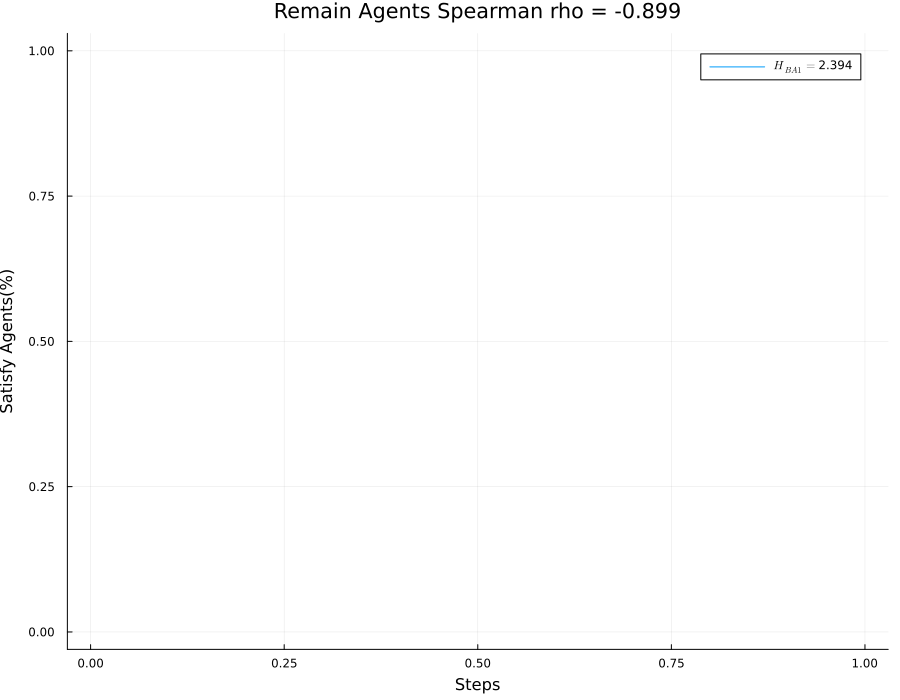

In [140]:
p7 = Plots.plot(remain, xlabel = "Steps",ylabel = "Satisfy Agents(%)",legend=true,labels = HGstr, title="Remain Agents Spearman rho = $(s_score_remain)", size=(900, 700))

In [141]:
entropy_ends = [graph_base_H[i][end] for i in 1:length(graph_base_H)]
s_score_entropy = corspearman(HGs, entropy_ends)
s_score_entropy = round(s_score_entropy; digits=3)

LoadError: MethodError: no method matching corspearman(::Vector{Any}, ::Vector{Any})

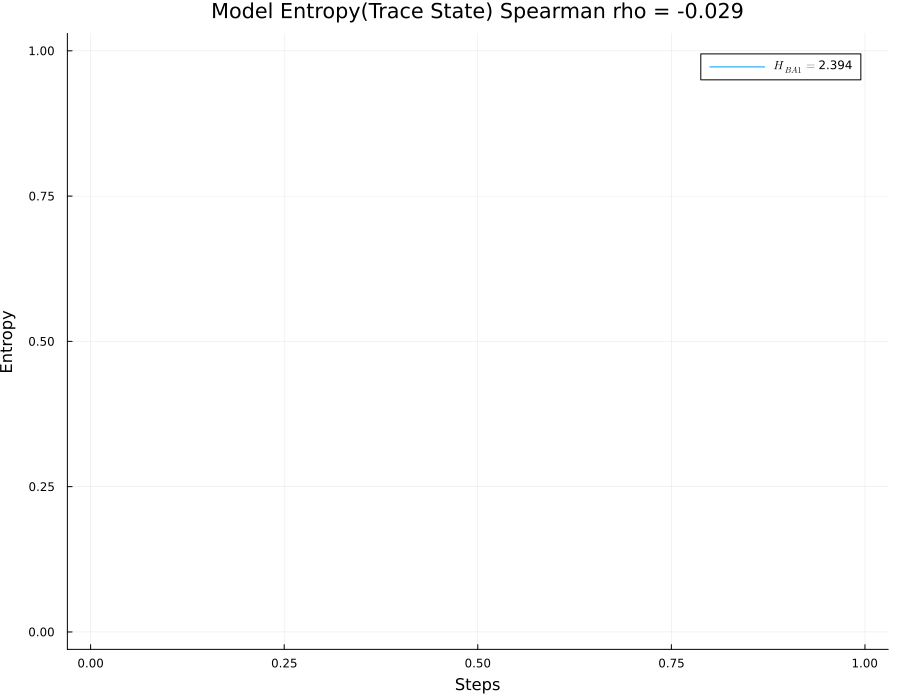

In [142]:
p4 = Plots.plot(graph_base_H, xlabel = "Steps",ylabel = "Entropy",legend=true, labels = HGstr,title="Model Entropy(Trace State) Spearman rho = $(s_score_entropy)", size=(900, 700))

In [143]:
map_model = initialize2(map_graph)

step_num = 100
step!(map_model, agent_step!, step_num)
pic = @drawsvg begin
    background("white")
    drawgraph(map_graph, 
        layout=positions,
        vertexshapes = VertexShape(map_graph, map_model),
        vertexshapesizes = [Graphs.outdegree(map_graph, v) for v in Graphs.vertices(map_graph)],
        vertexfillcolors = VertexFillColors(map_graph, map_model) )
    Karnak.text( "Map Graph Agent - Initial - Step:100", boxtopcenter() + (0, 10), halign=:center)
end

LoadError: UndefVarError: `map_graph` not defined